# EUCLIDEAN NORM DATASET DEMO

Let's us train the model to calculate the Euclidean norm, i.e., $\lvert \bar{x} \rvert _2 = \sqrt{\sum_{i=1}^n x_i^2}$

## DATA AND EVOTREES MODEL

### Required packages and files

In [1]:
using EvoTrees
using Plots
using Random
using Statistics
using Interpolations
include("plotting.jl");

### Create Euclidean norm data

In [26]:
Random.seed!(1)
n_feats = 5
data = randn(1000, n_feats)
data = data[shuffle(1:end), :]

split::Int = floor(0.75 * length(data[:, 1]))

x_train = data[1:split, :];
y_train = Array{Float64}(undef, length(x_train[:, 1]));
[y_train[i] = sqrt(sum(x_train[i, :].^2)) for i in 1:length(y_train)];

x_test = data[split+1:end, :];
y_test = Array{Float64}(undef, length(x_test[:, 1]));
[y_test[i] = sqrt(sum(x_test[i, :].^2)) for i in 1:length(y_test)];

### Get predictions from EvoTrees model with different forest sizes and tree depths

Testing part of data is used for calculating the coefficients of determination.

In [ ]:
trees = [5, 10, 25, 50, 100, 200, 500, 1000, 2000]
depths = [3, 5, 7, 10]
r2_values_test = Matrix{Float64}(undef, length(trees), length(depths))

for depth in eachindex(depths)

    config = EvoTreeRegressor(nrounds=maximum(trees), max_depth=depths[depth]);
    model = fit_evotree(config; x_train, y_train);

    for n_trees in eachindex(trees)

        pred_train = EvoTrees.predict(model, x_train, ntree_limit=trees[n_trees])
        pred_test = EvoTrees.predict(model, x_test, ntree_limit=trees[n_trees])
    
        nrmse_train = sqrt(mean((y_train .- pred_train).^2)) / mean(y_train)
        nrmse_test = sqrt(mean((y_test .- pred_test).^2)) / mean(y_test)
    
        r2_score_train = 1 - sum((y_train .- pred_train).^2) / sum((y_train .- mean(y_train)).^2)
        r2_score_test = 1 - sum((y_test .- pred_test).^2) / sum((y_test .- mean(y_test)).^2)
    
        r2_values_test[n_trees, depth] = r2_score_test
    
    end

end

### Plot results in a (heavily) interpolated graph

In [ ]:
plot_model_quality(trees, depths, r2_values_test, "Euclidean model R^2", "Number of trees", "Maximum depth")

From the graph it can be seen that the best results are achieved with forest sizes from $500$ to $1000$ and a maximum tree depth of $5$ or even less.

Poorer performance of deeper trees might be explained by overfitting.

### Model prediction visualised

Let's train a model with $1000$ trees and maximum tree depth of $5$.

┌ Info: EvoTreeRegressor{EvoTrees.Linear, Float32}
│  - nrounds: 1000
│  - lambda: 0.0
│  - gamma: 0.0
│  - eta: 0.1
│  - max_depth: 5
│  - min_weight: 1.0
│  - rowsample: 1.0
│  - colsample: 1.0
│  - nbins: 32
│  - alpha: 0.5
│  - monotone_constraints: Dict{Int64, Int64}()
│  - rng: TaskLocalRNG()
│  - device: cpu
└ @ EvoTrees /Users/eetureijonen/.julia/packages/EvoTrees/eBGfO/src/fit.jl:323


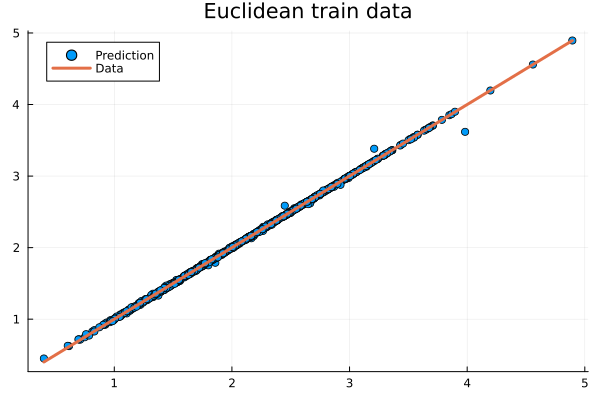

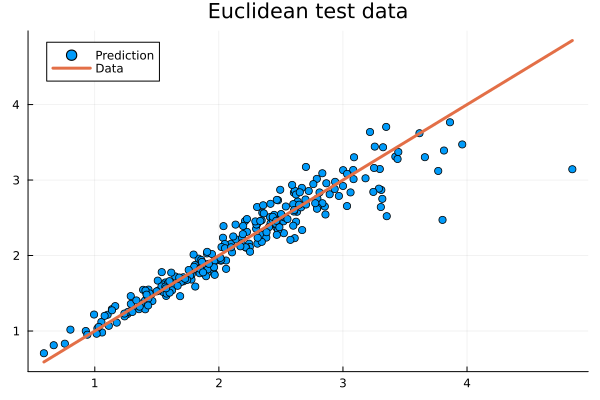

In [27]:
config = EvoTreeRegressor(nrounds=1000, max_depth=5);
model = fit_evotree(config; x_train, y_train);

pred_train = EvoTrees.predict(model, x_train)
pred_test = EvoTrees.predict(model, x_test)

display(plot(y_train, 
    [pred_train, y_train], 
    title="Euclidean train data", 
    label=["Prediction" "Data"], 
    markershape=[:circle :none], 
    seriestype=[:scatter :line], 
    lw=3))

plot(y_test, 
    [pred_test, y_test], 
    title="Euclidean test data", 
    label=["Prediction" "Data"], 
    markershape=[:circle :none], 
    seriestype=[:scatter :line], 
    lw=3)

The predictions are more dense with small values, since our random numbers are generated from a normal distribution. Taking the square root inflates the observations that would be very close to zero.

## MODEL OPTIMIZATION

### Package import and optimization implementation

In [11]:
using JuMP
using Gurobi

include("trees_to_relaxed_op.jl");

### Optimization of the model

First let's generate all constraints

In [48]:
x_new, sol_new, m_new = trees_to_relaxed_MIP(model, :createinitial, 5, :min);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-21
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29724 rows, 15442 columns and 100632 nonzeros
Model fingerprint: 0x500ef217
Variable types: 15287 continuous, 155 integer (155 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-08, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4.4505670
Presolve removed 12034 rows and 8153 columns
Presolve time: 0.20s
Presolved: 17690 rows, 7289 columns, 66245 nonzeros
Variable types: 7076 continuous, 213 integer (213 binary)
Found heuristic solution: objective 4.4498468

Root relaxation: objective 1.729941e-01, 10513 iterations, 1.63 seconds (5.29 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work

Then let's use the split constraint generation algorithm

In [49]:
x_alg, sol_alg, m_algo = trees_to_relaxed_MIP(model, :noconstraints, 5, :min);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-21
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1150 rows, 15442 columns and 15587 nonzeros
Model fingerprint: 0x5d61883c
Variable types: 15287 continuous, 155 integer (155 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-08, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1150 rows, 15442 columns, 15587 nonzeros
Variable types: 15287 continuous, 155 integer (155 binary)

Root relaxation: objective -1.623812e+00, 0 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -1.623

Although the number of constraints is drastically lower, the algorithm yields no time benefit for this tree model.

Generating the constraints likely becomes beneficial when the trees are deep, meaning that the amount of initial constraints grows exponentially.

In [50]:
println("Prediction of EvoTrees model without algorithm: $(EvoTrees.predict(model, reshape([mean(x_new[n]) for n in 1:n_feats], 1, n_feats))[1])")
println("Prediction of EvoTrees model with algorithm: $(EvoTrees.predict(model, reshape([mean(x_alg[n]) for n in 1:n_feats], 1, n_feats))[1])")
println("Minimum conceivable sum of tree predictions: $(sum(minimum(model.trees[tree].pred) for tree in 1:1001))")
println("Objective value without algorithm: $sol_new")
println("Objective value with algorithm: $sol_alg")
println("Minimum of the test dataset: $(minimum(pred_test))")
println("Zero vector predicted norm: $(EvoTrees.predict(model, reshape(zeros(n_feats), 1, n_feats))[1])")

Prediction of EvoTrees model without algorithm: 0.45030913
Prediction of EvoTrees model with algorithm: 0.88465476
Minimum conceivable sum of tree predictions: -1.6238121
Objective value without algorithm: 0.18748554467604972
Objective value with algorithm: -1.5290327627735678
Minimum of the test dataset: 0.70544666
Zero vector predicted norm: 0.5657395


### Problems with the solutions

The predictions of the tree model don't match the objective values for the "optimal" solutions.

Suspected problem is that the optimization model finds a solution that is better than should be possible, i.e., not all necessary constraints are added/satisfied.

Other possibility is that the objective function doesn't reflect the EvoTrees predict -function.

In [51]:
[mean(x_new[n]) for n in 1:n_feats]

5-element Vector{Float64}:
 -0.004130979999899864
 -0.004742370918393135
 -0.3429012894630432
  0.08091873675584793
  0.1515907682478428

In [52]:
x_new

5-element Vector{Vector}:
 [-0.04958237335085869, 0.04132041335105896]
 [-0.05115547403693199, 0.04167073220014572]
 [-0.39494407176971436, -0.29085850715637207]
 [0.04332612454891205, 0.11851134896278381]
 [0.08648312836885452, 0.21669840812683105]

### Guess and check -method

To find out whether the solution is optimal, we can just try every possible input around zero. EvoTrees.predict is too slow for checking all $32^5≈3.3 \cdot 10^7$ combinations.

In [46]:
splits_ordered = Array{Vector}(undef, n_feats)
[splits_ordered[feat] = [] for feat in 1:n_feats]

for tree in 1:1000
    for node in 1:2^(n_feats - 1)
        if model.trees[tree + 1].split[node] == true
            push!(splits_ordered[model.trees[tree + 1].feat[node]], model.trees[tree + 1].cond_float[node]) 
        end
    end
end
[unique!(sort!(splits_ordered[feat])) for feat in 1:n_feats]
splits_ordered

test_points = Array{Vector}(undef, n_feats)
[test_points[feat] = [(splits_ordered[feat][point] + splits_ordered[feat][point+1]) / 2 for point in 1:length(splits_ordered[feat])-1] for feat in 1:n_feats]
[prepend!(test_points[feat], -Inf) for feat in 1:n_feats]
[append!(test_points[feat], Inf) for feat in 1:n_feats]

predictions = []

append!(predictions, EvoTrees.predict(model, [test_points[1][f1] test_points[2][f2] test_points[3][f3] test_points[4][f4] test_points[5][f5]])[1] for f1 in 13:18, f2 in 13:18, f3 in 13:18, f4 in 13:18, f5 in 13:18)

7776-element Vector{Any}:
 0.7507302f0
 0.73396146f0
 0.68186295f0
 0.6801639f0
 0.7292123f0
 0.74060494f0
 0.7433657f0
 0.72659695f0
 0.66990983f0
 0.66806537f0
 ⋮
 0.65081316f0
 0.7051388f0
 0.7143986f0
 0.72519606f0
 0.7070883f0
 0.68550754f0
 0.66353834f0
 0.717864f0
 0.7271239f0

In [47]:
minimum(predictions)

0.45060885f0

The algorithm indeed seems to have found the optimal solution.